In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 8/1/2021 QAAFI UQ
# Code functionalities:
# In order to study the interactions between G and M under different climate conditions, climate zones
# can be created by kmeans clustering (Arthur and Vassilvitskii, 2007). The clustering is applied separately 
# to average mean daily temperature, sum solar radiation and rainfall during the crop growing season.

#Arthur, D., Vassilvitskii, S., 2007. k-means + +: the advantages of careful seeding.
#In: Proceedings of the Eighteenth Annual ACM-SIAM Symposium on Discrete
#Algorithms Society for Industrial and Applied Mathematics, New Orleans,
#Louisiana, pp. 1027–1035.
#####################################################################################################################

In [7]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [10]:
X1 = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\newenv.csv')
X0 = X1.drop(['Unnamed: 0'], axis=1)
X = X0.set_index(['lat', 'lon'])
X

rain_a       radn_a      rain_b       radn_b      rain_c  \
lat   lon                                                                    
25.25 -81.25  208.720205  1760.205241  399.064300  1587.924530  378.008811   
      -80.75  253.500109  1617.158845  439.977989  1463.146197  441.357791   
25.75 -81.75  195.829374  1778.060071  454.813932  1605.138435  384.780232   
      -81.25  229.691330  1727.683188  511.249461  1551.324274  415.540824   
      -80.75  274.451211  1578.892953  513.683174  1411.420895  444.733343   
...                  ...          ...         ...          ...         ...   
48.75 -93.75  144.157204  1328.623273  229.370940  1425.817929  175.696677   
      -93.25  145.607171  1328.975780  226.579531  1420.322649  172.952625   
      -92.75  146.788368  1329.872554  231.489734  1419.251681  187.225454   
49.25 -95.25  131.585768  1333.004352  221.010032  1444.030136  142.264659   
      -94.75  129.752621  1333.268867  216.389772  1443.723685  151.750544   

                   radn_c    wind_a      hur_a  hurtmax_a  cropland_a  ...  \
lat   lon                                                              ...   
25.25 -81.25  1360.146956  3.597331  71.568210  56.073944         0.0  ...   
      -80.75  1264.659323  3.656406  71.736855  58.279396         0.0  ...   
25.75 -81.75  1368.051625  3.260802  73.799330  57.699978         0.0  ...   
      -81.25  1332.511129  2.963778  66.274124  51.182804         0.0  ...   
      -80.75  1227.496463  3.282360  71.498790  56.944366         0.0  ...   
...                   ...       ...        ...        ...         ...  ...   
48.75 -93.75   808.187855  0.964755  57.775917  38.429394        35.0  ...   
      -93.25   805.028754  0.992344  58.628080  39.338177         0.0  ...   
      -92.75   805.222301  0.908360  58.021420  38.735825         0.0  ...   
49.25 -95.25   810.015374  2.132303  58.192856  38.171886         0.0  ...   
      -94.75   810.992794  2.446263  61.501920  41.295353         0.0  ...   

                tmean_c         radn         rain       tmin       tmax  \
lat   lon                                                                 
25.25 -81.25  27.746450  4708.276727   985.793316  24.188627  30.993357   
      -80.75  27.387226  4344.964365  1134.835888  24.247671  30.081070   
25.75 -81.75  27.606195  4751.250131  1035.423537  23.898031  30.925558   
      -81.25  27.413973  4611.518590  1156.481615  23.618965  30.483063   
      -80.75  27.460142  4217.810310  1232.867728  23.792383  30.200264   
...                 ...          ...          ...        ...        ...   
48.75 -93.75  10.397654  3562.629057   549.224821   6.575936  18.429190   
      -93.25  10.577308  3554.327182   545.139327   6.788812  18.505140   
      -92.75  10.321595  3554.346536   565.503555   6.411754  18.138662   
49.25 -95.25  10.380478  3587.049862   494.860459   6.582871  18.507822   
      -94.75  10.931805  3587.985346   497.892937   7.501684  18.731272   

                  tmean      wind        hur    hurtmax  cropland  
lat   lon                                                          
25.25 -81.25  27.590994  3.268429  81.542140  66.210000       0.0  
      -80.75  27.164370  3.356894  79.603455  66.424290       0.0  
25.75 -81.75  27.411795  2.946319  82.660400  66.636986       0.0  
      -81.25  27.051012  2.657388  79.238670  64.114230       0.0  
      -80.75  26.996325  2.962619  80.236580  65.923670       0.0  
...                 ...       ...        ...        ...       ...  
48.75 -93.75  12.502563  0.882636  60.905697  42.008694      35.0  
      -93.25  12.646976  0.911615  61.733868  42.859478       0.0  
      -92.75  12.275208  0.830661  62.547985  43.420452       0.0  
49.25 -95.25  12.545346  2.021087  60.424404  41.261883       0.0  
      -94.75  13.116478  2.345896  63.606200  44.404247       0.0  

[1860 rows x 36 columns]

In [14]:
#Calculate clusters using k-means

kmeans = KMeans(n_clusters=4, n_init=200, algorithm='elkan') 

y = kmeans.fit_predict(X[['rain_a', 'radn_a', 'rain_b', 'radn_b', 'rain_c',
       'radn_c', 'wind_a', 'hur_a', 'hurtmax_a', 'cropland_a', 'tmax_a',
       'tmin_a', 'tmean_a', 'wind_b', 'hur_b', 'hurtmax_b', 'cropland_b',
       'tmax_b', 'tmin_b', 'tmean_b', 'wind_c', 'hur_c', 'hurtmax_c',
       'cropland_c', 'tmax_c', 'tmin_c', 'tmean_c']])

X['env'] = y
#print(X)

In [15]:
#Calculate means and SD for Rad, Rain and Temp in each environment
mean_env = X.groupby(['env'])[['rain_a','rain_b','rain_c','radn_a','radn_b','radn_c','tmean_a', 'tmean_b','tmean_c']].mean().round(decimals=2)
#mean_env.rename(columns={'RadiationIn':'RadiationIn_m','TempIn':'TempIn_m','RainIn':'RainIn_m'}, inplace=True)

sd_env = X.groupby(['env'])[['rain_a','rain_b','rain_c','radn_a','radn_b','radn_c','tmean_a', 'tmean_b','tmean_c']].std().round(decimals=2)
#sd_env.rename(columns={'RadiationIn':'RadiationIn_sd','TempIn':'TempIn_sd','RainIn':'RainIn_sd'}, inplace=True)
#sd_env

envs = pd.concat([mean_env, sd_env], axis=1)
#envs.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\envs2.csv')

In [16]:
envs

,rain_a,rain_b,rain_c,radn_a,radn_b,radn_c,tmean_a,tmean_b,tmean_c,rain_a,rain_b,rain_c,radn_a,radn_b,radn_c,tmean_a,tmean_b,tmean_c
env,,,,,,,,,,,,,,,,,,
0,140.55,140.43,128.08,1569.99,1697.21,1245.83,19.80,27.03,21.34,50.59,30.67,40.77,104.48,41.36,58.86,4.02,2.27,3.32
1,255.38,228.83,210.60,1378.20,1527.61,1131.55,18.27,25.83,20.18,34.18,30.98,31.65,41.65,65.43,47.29,2.52,1.72,2.36
2,202.96,231.82,194.60,1295.02,1467.86,954.23,12.35,21.05,14.61,37.60,27.37,25.33,38.48,49.99,66.72,2.18,1.81,2.06
3,226.07,356.71,275.28,1523.63,1454.91,1189.61,22.23,27.49,23.87,38.18,68.44,55.92,75.89,47.47,50.79,1.64,0.59,1.66


In [85]:
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\KMEANS.csv')

In [17]:
#Convert dataframe to xarray to plot
df_env = X.to_xarray()
df_env

<xarray.Dataset>
Dimensions:     (lat: 49, lon: 70)
Coordinates:
  * lat         (lat) float64 25.25 25.75 26.25 26.75 ... 48.25 48.75 49.25
  * lon         (lon) float64 -106.8 -106.2 -105.8 ... -73.25 -72.75 -72.25
Data variables:
    rain_a      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    radn_a      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rain_b      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    radn_b      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rain_c      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    radn_c      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    wind_a      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hur_a       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hurtmax_a   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    cropland_a  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmax_a      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmin_a      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmean_a     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    wind_b      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hur_b       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hurtmax_b   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    cropland_b  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmax_b      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmin_b      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmean_b     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    wind_c      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hur_c       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hurtmax_c   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    cropland_c  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmax_c      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmin_c      (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmean_c     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    radn        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    rain        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmin        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmax        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    tmean       (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    wind        (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hur         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    hurtmax     (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    cropland    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    env         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

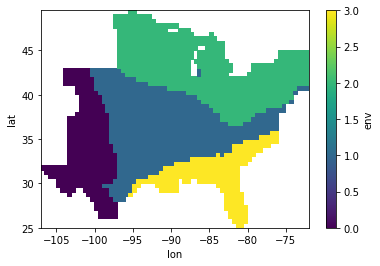

In [18]:
df_env.env[0:,0:].plot(yincrease=True, x='lon', y='lat')

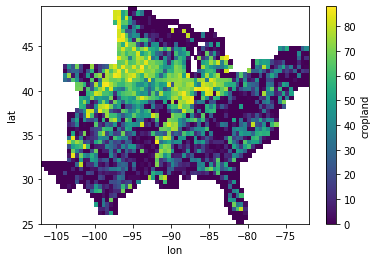

In [24]:
df_env.cropland[0:,0:].plot(yincrease=True, x='lon', y='lat')

In [19]:
#Create name for environments
X.loc[X.env == 0, 'env_name'] = "West"
X.loc[X.env == 1, 'env_name'] = "Mid"
X.loc[X.env == 2, 'env_name'] = "North"
X.loc[X.env == 3, 'env_name'] = "South"

In [20]:
X

rain_a       radn_a      rain_b       radn_b      rain_c  \
lat   lon                                                                    
25.25 -81.25  208.720205  1760.205241  399.064300  1587.924530  378.008811   
      -80.75  253.500109  1617.158845  439.977989  1463.146197  441.357791   
25.75 -81.75  195.829374  1778.060071  454.813932  1605.138435  384.780232   
      -81.25  229.691330  1727.683188  511.249461  1551.324274  415.540824   
      -80.75  274.451211  1578.892953  513.683174  1411.420895  444.733343   
...                  ...          ...         ...          ...         ...   
48.75 -93.75  144.157204  1328.623273  229.370940  1425.817929  175.696677   
      -93.25  145.607171  1328.975780  226.579531  1420.322649  172.952625   
      -92.75  146.788368  1329.872554  231.489734  1419.251681  187.225454   
49.25 -95.25  131.585768  1333.004352  221.010032  1444.030136  142.264659   
      -94.75  129.752621  1333.268867  216.389772  1443.723685  151.750544   

                   radn_c    wind_a      hur_a  hurtmax_a  cropland_a  ...  \
lat   lon                                                              ...   
25.25 -81.25  1360.146956  3.597331  71.568210  56.073944         0.0  ...   
      -80.75  1264.659323  3.656406  71.736855  58.279396         0.0  ...   
25.75 -81.75  1368.051625  3.260802  73.799330  57.699978         0.0  ...   
      -81.25  1332.511129  2.963778  66.274124  51.182804         0.0  ...   
      -80.75  1227.496463  3.282360  71.498790  56.944366         0.0  ...   
...                   ...       ...        ...        ...         ...  ...   
48.75 -93.75   808.187855  0.964755  57.775917  38.429394        35.0  ...   
      -93.25   805.028754  0.992344  58.628080  39.338177         0.0  ...   
      -92.75   805.222301  0.908360  58.021420  38.735825         0.0  ...   
49.25 -95.25   810.015374  2.132303  58.192856  38.171886         0.0  ...   
      -94.75   810.992794  2.446263  61.501920  41.295353         0.0  ...   

                     rain       tmin       tmax      tmean      wind  \
lat   lon                                                              
25.25 -81.25   985.793316  24.188627  30.993357  27.590994  3.268429   
      -80.75  1134.835888  24.247671  30.081070  27.164370  3.356894   
25.75 -81.75  1035.423537  23.898031  30.925558  27.411795  2.946319   
      -81.25  1156.481615  23.618965  30.483063  27.051012  2.657388   
      -80.75  1232.867728  23.792383  30.200264  26.996325  2.962619   
...                   ...        ...        ...        ...       ...   
48.75 -93.75   549.224821   6.575936  18.429190  12.502563  0.882636   
      -93.25   545.139327   6.788812  18.505140  12.646976  0.911615   
      -92.75   565.503555   6.411754  18.138662  12.275208  0.830661   
49.25 -95.25   494.860459   6.582871  18.507822  12.545346  2.021087   
      -94.75   497.892937   7.501684  18.731272  13.116478  2.345896   

                    hur    hurtmax  cropland  env  env_name  
lat   lon                                                    
25.25 -81.25  81.542140  66.210000       0.0    3     South  
      -80.75  79.603455  66.424290       0.0    3     South  
25.75 -81.75  82.660400  66.636986       0.0    3     South  
      -81.25  79.238670  64.114230       0.0    3     South  
      -80.75  80.236580  65.923670       0.0    3     South  
...                 ...        ...       ...  ...       ...  
48.75 -93.75  60.905697  42.008694      35.0    2     North  
      -93.25  61.733868  42.859478       0.0    2     North  
      -92.75  62.547985  43.420452       0.0    2     North  
49.25 -95.25  60.424404  41.261883       0.0    2     North  
      -94.75  63.606200  44.404247       0.0    2     North  

[1860 rows x 38 columns]

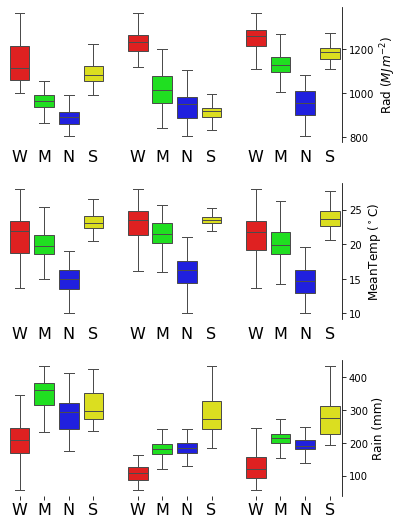

In [21]:
color_dict = dict({'West': '#ff0101','Mid':'#00ff01','North':'#0000fe','South':'#fafe00'})

fig= plt.figure(figsize=(6,9))

plt.subplot(3, 3, 1)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="radn_a", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 2)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="radn_b", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 3)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="radn_c", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rad ($MJ\,m^{-2}$)', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 4)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="tmean_a", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 5)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="tmean_b", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 6)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="tmean_c", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('MeanTemp ($^\circ$C)', fontsize =12)
plt.xlabel('', fontsize =12)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.tick_params(bottom=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 7)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="rain_a", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 8)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="rain_b", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, right=False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplot(3, 3, 9)
ax=sns.boxplot(x="env_name", order=['West','Mid','North','South'], y="rain_c", data=X, width=0.8,
            linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('Rain (mm)', fontsize =12)
plt.xlabel('')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=10)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

pos   = [0,1,2,3]
label = ['W','M','N','S']
ax.set_xticks(pos)
ax.set_xticklabels(label)

plt.subplots_adjust(wspace=0.2, hspace=0.3)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs_clim.png', dpi=600,bbox_inches='tight')

hide_toggle()

<ipython-input-23-70ebec16f6c6>:75: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


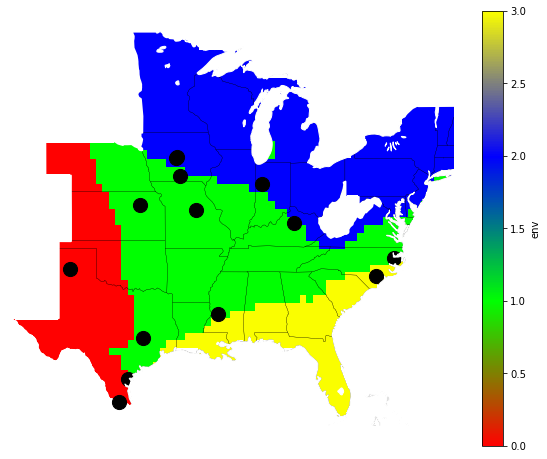

In [23]:
#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

colors = ['#ff0101','#00ff01','#0000fe','#fafe00']
cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env.env.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1, vmin=0, vmax=3)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

ax.outline_patch.set_visible(False)

# build and plot coordinates onto map
stations = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Python\all-stations.csv')
x = stations.lon
y = stations.lat
ax.scatter(stations.lon, stations.lat, marker='o', color='k', transform=ccrs.PlateCarree(),zorder=2, s=200)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAP.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [83]:
df_env3.cropland

<xarray.DataArray 'cropland' (lat: 49, lon: 70)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 25.25 25.75 26.25 26.75 ... 47.75 48.25 48.75 49.25
  * lon      (lon) float64 -106.8 -106.2 -105.8 -105.2 ... -73.25 -72.75 -72.25

<ipython-input-65-bf358577cc9b>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


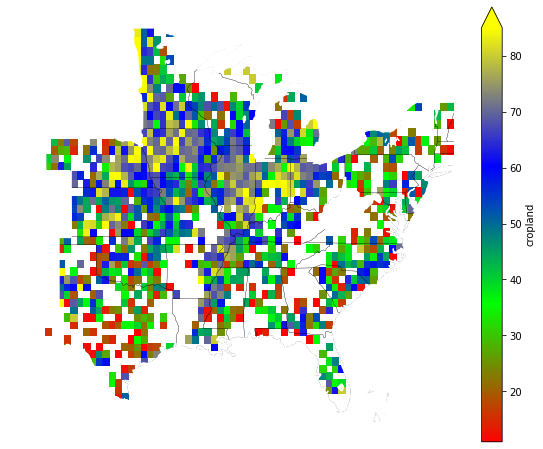

In [65]:
#df_env2 = df_env.assign(useland=lambda x: df_env.cropland > a limit)
df_env3 = df_env.where(df_env.cropland > 10)

#Plotting map with environmental zones
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(cmap_name, colors)

p=df_env3.cropland.plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=cm, add_colorbar=True, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\MAP.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [46]:
#X.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')
useland1 = df_env2.to_dataframe()
useland1.reset_index(drop=False, inplace=True)
useland0 = useland1.where(useland1['useland'] == True)
useland = pd.merge(useland0, X, how ='inner', on =['lat','lon'])
#useland.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')

<AxesSubplot:ylabel='Frequency'>

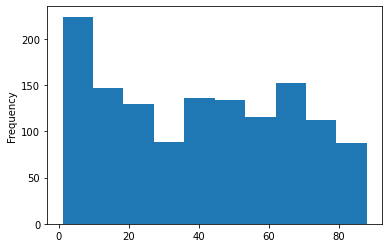

In [50]:
useland.cropland_a_y.plot.hist()

In [27]:
#Read mean created using nco from Linux
#data0 = xr.open_dataset(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\mean.nc', decode_times=False)

#Read output from psims
data00 = xr.open_dataset(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run016/output.nc4', decode_times=False) 

# replace all values equal to -99 with np.nan
dataPre4 = data00.where(data00['biomass'] > 3893.2174682617188) #df.biomass.quantile(0.025)
dataPre3 = dataPre4.where(dataPre4['FloweringDAS'] != -99.)

#Remove lat and lon combinations that were outside the study area. For this we need to convert the xarray to a 2D dataframe
#Conver multidimendional frame to 2D frame
data = dataPre3.to_dataframe()
data.reset_index(drop=False, inplace=True)

df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]

dropSet = {tuple(elem) for elem in coordinate_list}
# Creates a multi-index on letter/colour.
temp = data.set_index(['lat', 'lon'])
# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]
# Reset index to get the original column layout.
df_dropped = temp.reset_index()
dfc = df_dropped[df_dropped.biomass != 0]

#Change name of column
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()
df0 = df.where(df['biomass'] != 0)

In [28]:
#Merge dataframes to integrate the environment column with other variables
new2 = pd.merge(X, df0, how ='inner', on =['lat','lon']) 
#new2=new.drop(['RadiationIn_y','TempIn_y','RainIn_y','biomass_x'], axis=1)
new2.rename(columns={'biomass_y':'biomass'}, inplace=True)

#Change name of environments accordingly with levels of rad, rain and temp

new2.loc[new2.irr == 1, 'irr_name'] = "rainfed"
new2.loc[new2.irr == 2, 'irr_name'] = "irrigated"

new2.loc[new2.cultivar == 0, 'cv'] = "GS"
new2.loc[new2.cultivar == 1, 'cv'] = "SS"
new2.loc[new2.cultivar == 2, 'cv'] = "FSPS"
new2.loc[new2.cultivar == 3, 'cv'] = "FS"

#Calculate means before the plot
mean=new2.groupby(['env_name','irr_name'])[['biomass']].mean().round(decimals=0)

a=new2.groupby(['env_name','irr_name','cultivar','lat','lon'])[['biomass']].mean().round(decimals=0)

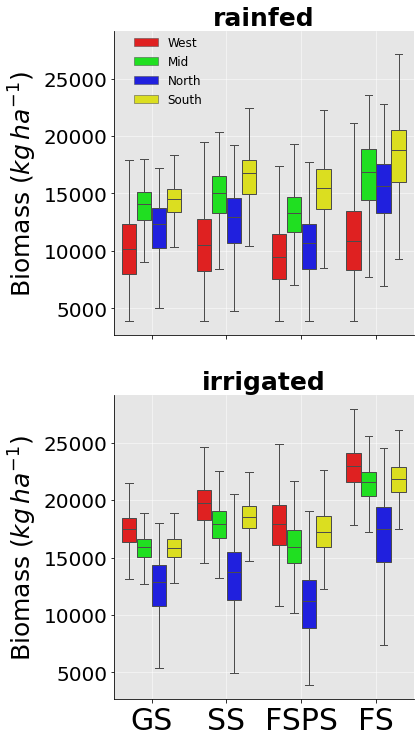

In [51]:
#Plot biomass by environment, cultivar and irrigation management
color_dict = dict({'West': '#ff0101','Mid':'#00ff01','North':'#0000fe','South':'#fafe00'})

tkt_plot_detailed =sns.catplot(x="cv", order=['GS','SS','FSPS','FS'], y="biomass", data=new2, hue='env_name', 
                               hue_order=['West','Mid','North','South'], linewidth=1, kind='box', col='irr_name', 
                               col_wrap=1, legend=False, showfliers = False, palette=color_dict)

tkt_plot_detailed.set_axis_labels("", "Biomass ($kg\,ha^{-1}$)",fontsize= 25)
tkt_plot_detailed.set_titles(col_template="{col_name}", fontweight='bold', size=25)

for ax in tkt_plot_detailed.axes.flatten():

    ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
    ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
    ax.patch.set_facecolor('0.90')
    ax.set_axisbelow(True)
    ax.yaxis.set_tick_params(labelsize=20)
    ax.xaxis.set_tick_params(labelsize=30)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    pos   = [0, 1, 2, 3]
    label = ['GS','SS','FSPS','FS']
    ax.set_xticks(pos)
    ax.set_xticklabels(label)

plt.legend(prop=dict(size=12),bbox_to_anchor=(0.05, 2.2), loc=2, borderaxespad=0., frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\envs.png', dpi=300,bbox_inches='tight')
hide_toggle()

(0.0, 29.0)

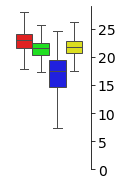

In [52]:
#Create subset of dataframes to create singular plots for biomass
new2['biomass2']=new2['biomass']/1000

rainfed = new2.where(new2['irr_name'] == 'rainfed')
irrigated = new2.where(new2['irr_name'] == 'irrigated')

GSd = rainfed.where(rainfed['cv'] == 'GS')
SSd = rainfed.where(rainfed['cv'] == 'SS')
FSPSd = rainfed.where(rainfed['cv'] == 'FSPS')
FSd = rainfed.where(rainfed['cv'] == 'FS')

GSi = irrigated.where(irrigated['cv'] == 'GS')
SSi = irrigated.where(irrigated['cv'] == 'SS')
FSPSi = irrigated.where(irrigated['cv'] == 'FSPS')
FSi = irrigated.where(irrigated['cv'] == 'FS')

#Plot biomass by environment, cultivar and irrigation management

fig = plt.figure(figsize=(1.5,3))
color_dict = dict({'West': '#ff0101','Mid':'#00ff01','North':'#0000fe','South':'#fafe00'})
ax=sns.boxplot(x="cv", y="biomass2", data=FSi, hue='env_name', hue_order=['West','Mid','North','South'], linewidth=1, showfliers = False, palette=color_dict)
plt.ylabel('', fontsize =13)
plt.xlabel('', fontsize =13)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_tick_params(labelsize=14, rotation=0)
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
plt.tick_params(axis='x',bottom=False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.get_legend().remove()
ax.set_ylim([0,29])

fig.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\env1.png', dpi=300,bbox_inches='tight',transparent=True)

In [17]:
#Saving xarray as nc file
#df_env.to_netcdf(r"C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\env.nc")